In [1]:
import time

# Your choice of plotting front-end.
%matplotlib inline

import ROOT
tcanvas = ROOT.TCanvas("TCanvasName", "TCanvasTitle", 800, 300)

Welcome to JupyROOT 6.08/05


In [2]:
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_0.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_1.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_2.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_3.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_4.root .

[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] OS Error: File exists
[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] OS Error: File exists
[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] OS Error: File exists
[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] OS Error: File exists
[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] OS Error: File exists


In [3]:
tchain = ROOT.TChain()
tchain.Add("sig_shuffled_0.root/tree")
tchain.Add("sig_shuffled_1.root/tree")
tchain.Add("sig_shuffled_2.root/tree")
tchain.Add("sig_shuffled_3.root/tree")
tchain.Add("sig_shuffled_4.root/tree")
list(tchain.GetListOfBranches())

[<ROOT.TBranch object ("ph_N") at 0x7691510>,
 <ROOT.TBranchElement object ("ph_pdgId") at 0x769bad0>,
 <ROOT.TBranchElement object ("ph_charge") at 0x76a40e0>,
 <ROOT.TBranchElement object ("ph_e") at 0x76a47f0>,
 <ROOT.TBranchElement object ("ph_eta") at 0x76a4f00>,
 <ROOT.TBranchElement object ("ph_phi") at 0x76a5610>,
 <ROOT.TBranchElement object ("ph_mass") at 0x76a5d20>,
 <ROOT.TBranchElement object ("ph_pt") at 0x76a6430>,
 <ROOT.TBranchElement object ("ph_et") at 0x76a6b40>,
 <ROOT.TBranchElement object ("ph_rho") at 0x76a7250>,
 <ROOT.TBranchElement object ("ph_superCluster_eta") at 0x76a7960>,
 <ROOT.TBranchElement object ("ph_superCluster_phi") at 0x76a8100>,
 <ROOT.TBranchElement object ("ph_sigmaIetaIeta") at 0x76a88d0>,
 <ROOT.TBranchElement object ("ph_hOverE") at 0x76a90a0>,
 <ROOT.TBranchElement object ("ph_isoGamma") at 0x76a97b0>,
 <ROOT.TBranchElement object ("ph_isoCh") at 0x76a9ec0>,
 <ROOT.TBranchElement object ("ph_passEleVeto") at 0x76aa5d0>,
 <ROOT.TBranchElem

In [4]:
tchain.SetBranchStatus("*", 0)
for branch in ["jetAK4_N",
               "jetAK4_pt",
               "jetAK4_eta",
               "jetAK4_mass",
               "jetAK4_phi",
               "jetAK4_e",
               "jetAK4_jec",
               "jetAK4_IDLoose"]:
    tchain.SetBranchStatus(branch, 1)

In [5]:
dijetMass_hist = ROOT.TH1D("dijetMass_hist", "dijet mass [GeV]", 100, 0, 1000)
dijetEtBalance_hist = ROOT.TH1D("dijetEtBalance_hist", "dijet ET balance", 100, 0, 1)
cosThetaStar_hist = ROOT.TH1D("cosThetaStar_hist", "cos(theta*)", 100, -1, 1)

leadingJet = ROOT.TLorentzVector()
subleadingJet = ROOT.TLorentzVector()

startTime = time.time()
for event in tchain:
    if event.jetAK4_N < 2:
        continue
    
    leadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(0),
                            event.jetAK4_eta.at(0),
                            event.jetAK4_phi.at(0),
                            event.jetAK4_e.at(0))
    
    subleadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(1),
                               event.jetAK4_eta.at(1),
                               event.jetAK4_phi.at(1),
                               event.jetAK4_e.at(1))
    
    dijet = leadingJet + subleadingJet

    boostedLeadingJet = leadingJet
    boostedLeadingJet.Boost(-dijet.BoostVector())
    
    dijetMass_hist.Fill(dijet.M())
    dijetEtBalance_hist.Fill(subleadingJet.Et() / leadingJet.Et())
    cosThetaStar_hist.Fill(boostedLeadingJet.Pz() / boostedLeadingJet.P())

endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 10.7659780979 seconds.


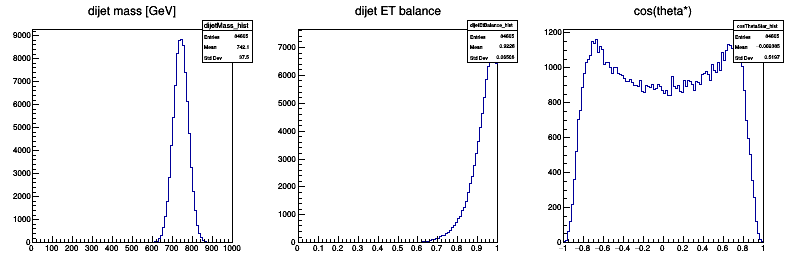

In [6]:
tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist.Draw()
tcanvas.cd(2); dijetEtBalance_hist.Draw()
tcanvas.cd(3); cosThetaStar_hist.Draw()
tcanvas.Draw()

In [7]:
from histogrammar import *

Bundle = UntypedLabel    # a naming convention we'll be changing to in Histogrammar 2.0

def cosThetaStar(jets):
    boostedLeading = jets[0]
    boostedLeading.Boost(-(jets[0] + jets[1]).BoostVector())
    return boostedLeading.Pz() / boostedLeading.P()

histograms = Bundle(
    dijetMass      = Bin(100, 0, 1000, lambda jets: (jets[0] + jets[1]).M()),
    dijetEtBalance = Bin(100, 0, 1, lambda jets: jets[1].Et() / jets[0].Et()),
    cosThetaStar   = Bin(100, -1, 1, cosThetaStar))

leadingJet = ROOT.TLorentzVector()
subleadingJet = ROOT.TLorentzVector()

startTime = time.time()
for event in tchain:
    if event.jetAK4_N < 2:
        continue
    
    leadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(0),
                            event.jetAK4_eta.at(0),
                            event.jetAK4_phi.at(0),
                            event.jetAK4_e.at(0))
    
    subleadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(1),
                               event.jetAK4_eta.at(1),
                               event.jetAK4_phi.at(1),
                               event.jetAK4_e.at(1))
    
    histograms.fill([leadingJet, subleadingJet])

endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 17.8560531139 seconds.


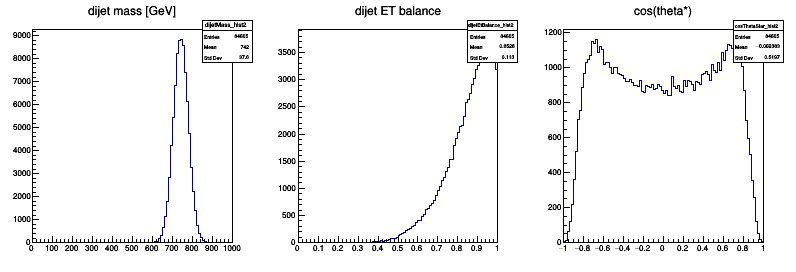

In [8]:
dijetMass_hist2 = histograms.get("dijetMass").plot.root("dijetMass_hist2", "dijet mass [GeV]")
dijetEtBalance_hist2 = histograms.get("dijetEtBalance").plot.root("dijetEtBalance_hist2", "dijet ET balance")
cosThetaStar_hist2 = histograms.get("cosThetaStar").plot.root("cosThetaStar_hist2", "cos(theta*)")

tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist2.Draw()
tcanvas.cd(2); dijetEtBalance_hist2.Draw()
tcanvas.cd(3); cosThetaStar_hist2.Draw()
tcanvas.Draw()

In [9]:
# yes, we're creating new TLorentzVectors, but on the stack, which is faster than allocation with "new"
ROOT.gInterpreter.Declare("""
TLorentzVector lorentzVector(int i, vector<float>& pt, vector<float>& eta, vector<float>& phi, vector<float>& e) {
    TLorentzVector out;
    out.SetPtEtaPhiE(pt.at(i), eta.at(i), phi.at(i), e.at(i));
    return out;
}
""")

ROOT.gInterpreter.Declare("""
double cosThetaStar(TLorentzVector leadingJet, TLorentzVector subleadingJet) {
    leadingJet.Boost(-(leadingJet + subleadingJet).BoostVector());
    return leadingJet.Pz() / leadingJet.P();
}
""")

True

In [10]:
histograms = Select("jetAK4_N >= 2", Bundle(
    dijetMass = Bin(100, 0, 1000, """
        (lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e) +
         lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e)
        ).M()
    """),
    dijetEtBalance = Bin(100, 0, 1, """
        lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e).Et() /
        lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e).Et()
    """),
    cosThetaStar   = Bin(100, -1, 1, """cosThetaStar(
        lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e),
        lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e))""")
))

startTime = time.time()
histograms.fill.root(tchain)
endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 1.16216921806 seconds.


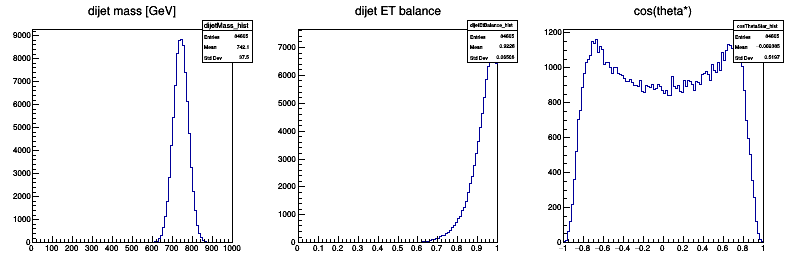

In [11]:
dijetMass_hist3 = histograms.get("dijetMass").plot.root("dijetMass_hist3", "dijet mass [GeV]")
dijetEtBalance_hist3 = histograms.get("dijetEtBalance").plot.root("dijetEtBalance_hist3", "dijet ET balance")
cosThetaStar_hist3 = histograms.get("cosThetaStar").plot.root("cosThetaStar_hist3", "cos(theta*)")

tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist.Draw()
tcanvas.cd(2); dijetEtBalance_hist.Draw()
tcanvas.cd(3); cosThetaStar_hist.Draw()
tcanvas.Draw()

In [12]:
!root -l rootmacro.C++

root [0] 
Processing rootmacro.C++...
Info in <TUnixSystem::ACLiC>: creating shared library /uscms_data/d2/pivarski/CMSSW_9_0_1/src/scientific-python-hats/histogrammar/./rootmacro_C.so
This took 0.770954 seconds.


In [31]:
barchart = Categorize(lambda x: x)
barchart.fill("PyROOT", 10.76)
barchart.fill("Hg Python", 17.85)
barchart.fill("Hg C++", 1.16)
barchart.fill("pure C++", 0.77)

AttributeError: 'module' object has no attribute 'CategorizeHistogramMethods'

['FractionedHistogramMethods',
 'HistogramMethods',
 'PartitionedHistogramMethods',
 'ProfileErrMethods',
 'ProfileMethods',
 'SparselyHistogramMethods',
 'SparselyProfileErrMethods',
 'SparselyProfileMethods',
 'SparselyTwoDimensionallyHistogramMethods',
 'StackedHistogramMethods',
 'TwoDimensionallyHistogramMethods',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'absolute_import',
 'prepare2Dsparse',
 'set2Dsparse',
 'types']